# Import packages

In [1]:
import sys
sys.path.append('../src/')
from tools import get_coma_results, generate_ids_paths, columns_to_profiles, create_profiles_tensor, create_configuration
from graph import create_relatedness_graphs
from train import negative_sampling_3
from train import train_model
from train import compute_all_probs_labels, compute_probabilities_labels
from train import metrics
import pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score

import torch
import pickle
import numpy as np
import re
import matplotlib.pyplot as plt

Using backend: pytorch


# Dataset preperation and profiling

In [2]:
path_to_datasets ="../datasets/nydata/derived_tables/"
cols_to_ids, files_to_paths = generate_ids_paths(path_to_datasets)

## Profiling

### If not pre-computed

In [ ]:
cols_profiles = columns_to_features(files_to_paths)  # run this if profiles have not been pre-computed

### If pre-computed

In [3]:
profiles_file = '../profiles/nydata_profiles.pickle'
with open(profiles_file, 'rb') as file:
    cols_profiles= pickle.load(file)

In [4]:
profiles_tensor = create_profiles_tensor(cols_profiles, cols_to_ids)

## Group derived datasets per base table

In [5]:
cols = list(cols_to_ids.keys())

base_derived = dict()

for c in cols:
    match = re.match(r"([a-z0-9_]+)_([0-9]+)", c[0], re.I)   
    if match[1] in base_derived:
        base_derived[match[1]].append(c[0])
    else:
        base_derived[match[1]] = [c[0]]

for c,t in base_derived.items():    
    t = list(set(t))
    base_derived[c] = t

# Construct relatedness graphs

## Configure silos

### Compute random configuration

In [ ]:
silo_configuration = create_configuratione(category_tables, 4, 4, 10, 'random') # construct 10 silos where we sample exactly 4 datasets per base table (base tables selected randomly)

### Load configuration from paper

In [6]:
configuration_file = '../configurations/ny_silos.pickle'
with open(configuration_file, 'rb') as file:
    silo_configuration = pickle.load(file)

## Load ground truth of matches

In [7]:
matches_file = '../ground_truth/matches_nydata.csv'
matches_df = pd.read_csv(matches_file)

ground_truth = []
for index, row in matches_df.iterrows():
    ground_truth.append(((row['Dataset-1'][:-4], row['Column-1']), (row['Dataset-2'][:-4], row['Column-2'])))

## Construct relatedness graphs

In [8]:
graphs, all_columns, all_cols_ids, all_ids_cols = create_relatedness_graphs(base_derived, cols_to_ids, profiles_tensor.tolist(), ground_truth, silo_configuration)

## Get negative samples from all relatedness graphs

In [9]:
graphs_neg = dict()

for i in range(len(graphs)):
    graphs_neg[i] = negative_sampling_3(graphs[i]) # use negative sampling strategy #3 from the paper

# Train model

In [10]:
model = train_model(graphs, graphs_neg, 10, 256, incremental= True) # train incrementally for 10 epochs per relatedness graph

In epoch 0, loss 1.313627004623413, f1 0.9503668546676636
In epoch 0, loss 0.9744166731834412, f1 0.759617805480957
In epoch 0, loss 0.49144020676612854, f1 0.8502852916717529
In epoch 0, loss 0.3284056782722473, f1 0.9288066029548645
In epoch 0, loss 0.10556533932685852, f1 0.9645335674285889
In epoch 0, loss 0.07025700062513351, f1 0.9845767021179199
In epoch 0, loss 0.05114539712667465, f1 0.986910343170166
In epoch 0, loss 0.11215249449014664, f1 0.9938979744911194
In epoch 0, loss 0.026969680562615395, f1 0.9934335947036743
In epoch 0, loss 0.02096991427242756, f1 0.9965035319328308


## Embed all nodes based on the trained model

In [11]:
embeddings = dict()

for j in range(len(graphs)):

    embeddings[j] = model.gnn(graphs[j], graphs[j].ndata['feat']).detach()

## Compute precision and recall values for different thresholds

In [12]:
probabilities, labels = compute_all_probs_labels(all_columns, all_cols_ids, embeddings, ground_truth, model, len(graphs))
precision_sima, recall_sima, thresholds_sima = precision_recall_curve(probabilities, labels)    

Computing between graphs: 0 - 1
Computing between graphs: 0 - 2
Computing between graphs: 0 - 3
Computing between graphs: 0 - 4
Computing between graphs: 0 - 5
Computing between graphs: 0 - 6
Computing between graphs: 0 - 7
Computing between graphs: 0 - 8
Computing between graphs: 0 - 9
Computing between graphs: 1 - 2
Computing between graphs: 1 - 3
Computing between graphs: 1 - 4
Computing between graphs: 1 - 5
Computing between graphs: 1 - 6
Computing between graphs: 1 - 7
Computing between graphs: 1 - 8
Computing between graphs: 1 - 9
Computing between graphs: 2 - 3
Computing between graphs: 2 - 4
Computing between graphs: 2 - 5
Computing between graphs: 2 - 6
Computing between graphs: 2 - 7
Computing between graphs: 2 - 8
Computing between graphs: 2 - 9
Computing between graphs: 3 - 4
Computing between graphs: 3 - 5
Computing between graphs: 3 - 6
Computing between graphs: 3 - 7
Computing between graphs: 3 - 8
Computing between graphs: 3 - 9
Computing between graphs: 4 - 5
Computin

# Load COMA results

In [14]:
coma_resuls_file = '../coma_results/nydata_coma_results.json'
coma_results = get_coma_results(coma_resuls_file, all_cols_ids)

## Compute precision and recall values for different thresholds

In [15]:
labels, probabilities = compute_probabilities_labels(coma_results, ground_truth)
precision_coma, recall_coma, thresholds_coma = precision_recall_curve(labels, probabilities)

# Plot results

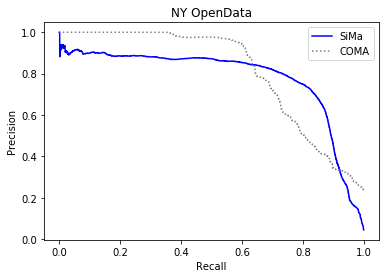

In [16]:
fig, ax = plt.subplots()

ax.plot(recall_sima, precision_sima, color='blue')

ax.plot(recall_coma, precision_coma, color = 'grey', linestyle='dotted')

plt.legend(["SiMa", "COMA"], loc=0, frameon=True)

#add axis labels to plot
ax.set_title('NY OpenData')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()